In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [20]:
# Load the train, validation, and test datasets
train_data = pd.read_csv('../date/train_data.csv')
val_data = pd.read_csv('../date/val_data.csv')
test_data = pd.read_csv('../date/test_data.csv')

In [21]:
#Encode 'Origin/Ethnicity' and 'Genre'
label_encoder = LabelEncoder()
train_data['Origin/Ethnicity'] = label_encoder.fit_transform(train_data['Origin/Ethnicity'])
val_data['Origin/Ethnicity'] = label_encoder.transform(val_data['Origin/Ethnicity'])
test_data['Origin/Ethnicity'] = label_encoder.transform(test_data['Origin/Ethnicity'])
train_data['Genre'] = label_encoder.fit_transform(train_data['Genre'])
val_data['Genre'] = label_encoder.transform(val_data['Genre'])
test_data['Genre'] = label_encoder.transform(test_data['Genre'])

In [22]:
# Tokenize 'Title' and 'Cast' for Word2Vec
train_data['Title_Tokens'] = train_data['Title'].fillna('').apply(lambda x: x.split())
train_data['Cast_Tokens'] = train_data['Cast'].fillna('').apply(lambda x: x.split(','))
# Train Word2Vec models on train data
title_w2v_model = Word2Vec(sentences=train_data['Title_Tokens'], vector_size=10, window=3, min_count=1, workers=4)
cast_w2v_model = Word2Vec(sentences=train_data['Cast_Tokens'], vector_size=10, window=3, min_count=1, workers=4)

In [23]:
# Function to get Word2Vec embeddings
def get_w2v_embedding(tokens, model, vector_size):
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

In [24]:
# Generate embeddings for 'Title' and 'Cast' in all datasets
for dataset in [train_data, val_data, test_data]:
    dataset['Title_Embedding'] = dataset['Title'].fillna('').apply(
        lambda x: get_w2v_embedding(x.split(), title_w2v_model, 10)
    )
    dataset['Cast_Embedding'] = dataset['Cast'].fillna('').apply(
        lambda x: get_w2v_embedding(x.split(','), cast_w2v_model, 10)
    )

In [25]:

# Expand embedding columns into separate features
def process_embeddings(data):
    title_embeddings = np.vstack(data['Title_Embedding'].values)
    cast_embeddings = np.vstack(data['Cast_Embedding'].values)
    numeric_features = data[['Release Year', 'Origin/Ethnicity']].values
    max_title_embedding = np.max(title_embeddings, axis=1).reshape(-1, 1)
    max_cast_embedding = np.max(cast_embeddings, axis=1).reshape(-1, 1)
    var_title_embedding = np.var(title_embeddings, axis=1).reshape(-1, 1)
    var_cast_embedding = np.var(cast_embeddings, axis=1).reshape(-1, 1)
    std_title_embedding = np.std(title_embeddings, axis=1).reshape(-1, 1)
    std_cast_embedding = np.std(cast_embeddings, axis=1).reshape(-1, 1)
    
    combined_features = np.hstack((
        numeric_features,
        title_embeddings,
        cast_embeddings,
        max_title_embedding,
        max_cast_embedding,
        var_title_embedding,
        var_cast_embedding,
        std_title_embedding,
        std_cast_embedding
    ))
    return combined_features

In [26]:
# Process embeddings for train, validation, and test datasets
X_train = process_embeddings(train_data)
y_train = train_data['Genre']

X_val = process_embeddings(val_data)
y_val = val_data['Genre']

X_test = process_embeddings(test_data)
y_test = test_data['Genre']

In [27]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [28]:
# Standardize all features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [29]:
# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [200, 300],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [0.01, 0.1]
}

In [30]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), seed=42)

# Perform grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train_resampled)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=6,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [200, 300], 'reg_alpha': [0.01, 0.1],
                         'reg_lambda': [0.01, 0.1], 'subsample': [0.8]},
             scoring='accuracy', verbose=1)

In [31]:
# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

# Evaluate the model on the validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.74
Validation Accuracy: 0.41
Test Accuracy: 0.40


C:\Users\User\AppData\Local\Temp\ipykernel_15576\4063336170.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


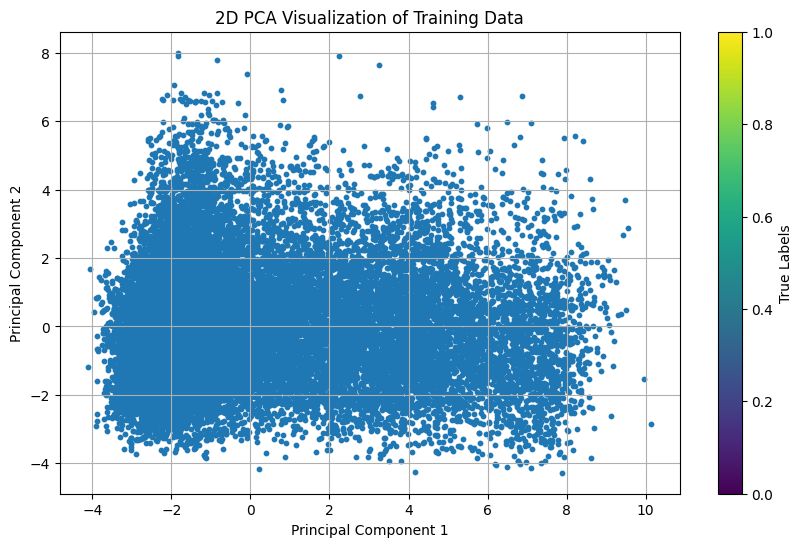

In [32]:
# PCA Visualization for Train Data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    cmap='viridis',
    s=10
)
plt.colorbar(scatter, label="True Labels")
plt.title("2D PCA Visualization of Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
# Confusion Matrix for Test Data

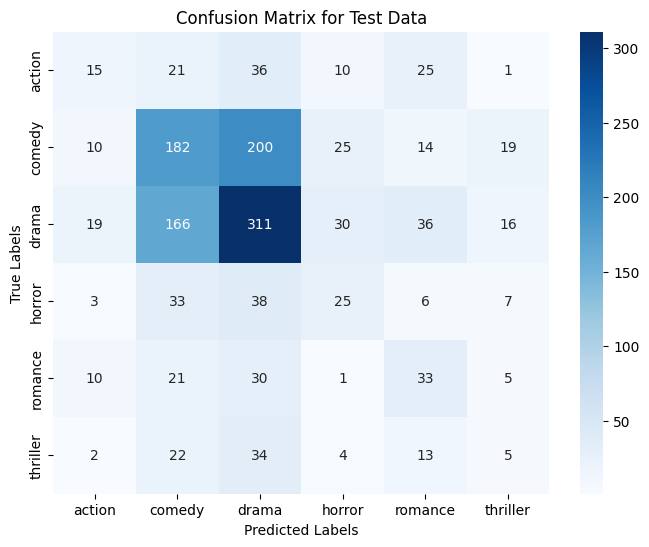

Classification Report for Test Data:
              precision    recall  f1-score   support

      action       0.25      0.14      0.18       108
      comedy       0.41      0.40      0.41       450
       drama       0.48      0.54      0.51       578
      horror       0.26      0.22      0.24       112
     romance       0.26      0.33      0.29       100
    thriller       0.09      0.06      0.08        80

    accuracy                           0.40      1428
   macro avg       0.29      0.28      0.28      1428
weighted avg       0.39      0.40      0.39      1428



In [33]:

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report for Test Data
print("Classification Report for Test Data:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

Contingency Matrix:
Predicted Labels   0    1    2   3   4   5
True Labels                               
0                 15   21   36  10  25   1
1                 10  182  200  25  14  19
2                 19  166  311  30  36  16
3                  3   33   38  25   6   7
4                 10   21   30   1  33   5
5                  2   22   34   4  13   5


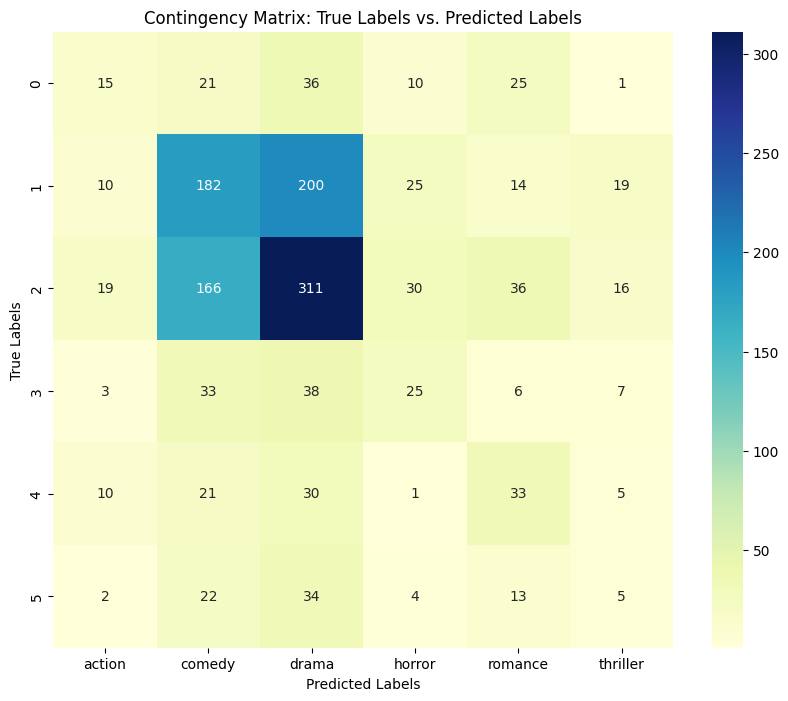

In [34]:
# Create a contingency matrix (True Labels vs. Predicted Labels)
contingency_matrix = pd.crosstab(y_test, y_test_pred, rownames=['True Labels'], colnames=['Predicted Labels'])

# Display the contingency matrix
print("Contingency Matrix:")
print(contingency_matrix)

# Visualize the contingency matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    contingency_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    xticklabels=label_encoder.classes_,
)
plt.title("Contingency Matrix: True Labels vs. Predicted Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [35]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Calculate ARI and NMI
ari_score = adjusted_rand_score(y_test, y_test_pred)
nmi_score = normalized_mutual_info_score(y_test, y_test_pred)

# Print ARI and NMI
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")


Adjusted Rand Index (ARI): 0.0629
Normalized Mutual Information (NMI): 0.0509
